In [2]:
import numpy as np
import itertools
from random import randrange, uniform
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define previous functions

Before we tackle the problem, let us define some functions that will be useful later on. 

They are simple functions used to compute kronecker products and density matrices or to extend an operator that acts on a reduced set of qubits to act on a larger system, among others. One can skip this part of the code since it is not directly related to our problem. 

In [3]:
def kron_(operators): 

    """ Compute kronecker product of the `operators` in the given order. """

    A = operators[0]
    for i in range(len(operators)-1): 
        A = np.kron(A, operators[i+1])
    return A

def ket_to_vec(ket):

    """ Return the  2**N basis vector that corresponds to `ket`, where `N` is the length of the string `ket` (number of qubits). 
    
    Example
    --------
    >>> ket = '01'
    >>> ket_to_vec(ket)
    array([0., 1., 0., 0.]) """

    vec_basis = int(ket, 2)
    N = len(ket)
    vec = np.zeros(2**N)
    vec[vec_basis] = 1
    return vec

def dagger(U):
    """ Return the conjugate transpose of the matrix `U`. """
    return np.transpose(U.conj()) # IS

def density_matrix(state): 

    """ Return the density matrix of `state`"""

    s = np.reshape(state, (np.size(state),1))
    return s@dagger(s)

def isunitary(U):
    """ Check if matrix `U` is unitary. """
    assert np.shape(U)[0] == np.shape(U)[1], "Non-square matrix"
    n = np.linalg.norm(U@dagger(U) - np.eye(np.shape(U)[0]))
    if n < 1e-10:
        return(True)
    else: return(False)
    
def extend_operator(H, ind, N):

    """ Extend the operator `H` that acts on qubits `(ind[0], ind[1],...,ind[M-1])` to an operator that acts on 
    the whole system of  `N` qubits, by acting trivially as the identity in the rest of qubits."""

    if np.log2(np.shape(H)[0]) != np.log2(np.shape(H)[1]):
        raise NameError('Must be square matrix')

    M = int(np.log2(np.shape(H)[0])) #number of qubits in which H acts
    
    assert M == len(ind)
    identity_rest = np.eye(2**(N-M))
    H_reshape = np.reshape(np.kron(H, identity_rest), (2*N)*(2,))
    H_swap = np.moveaxis(H_reshape, [*range(M)]+[[*range(M)][i]+N for i in range(M)], ind+ [ind[i]+N for i in range(len(ind))])
    return np.reshape(H_swap, (2**N, 2**N))

# Construction of a quantum circuit

We procceed now to construct a quantum circuit. This is defined as a class with the following attributes: 

* $\texttt{nqubits}$: number of registers that the quantum circuit has. 
* $\texttt{gates}$: list of gates that compose the circuit. Their are ordered in the same way as should be applied in the circuit. 

Gate is another class, that has the following attributes: 
* $\texttt{matrix}$: the matrix representation of the gate.
* $\texttt{wires}$: list of the qubit registers in which the gate acts on. 

In [4]:
class Gate:
    
    def __init__(self, matrix, wires):
        self.matrix = matrix
        self.wires = wires

In [5]:
class Qcircuit:
    
    def __init__(self, nqubits):
        self.nqubits = nqubits
        self.gates = []
    

    def add_gate(self, Gate):
        self.gates.append(Gate)
   
    def simulate(self, input_state): 
        U = np.eye(2**self.nqubits)
        for g in self.gates: 
            gextend = extend_operator(g.matrix, g.wires, self.nqubits)
            U = gextend@U

        output_state = U@input_state
        return output_state

# Define some gates

Let us define some gates that we will use throught the resolution of the problem. 

These consists on paradigmatic gates as the Pauli matrices, CNOT, Hadamard and the rotation gates $R_y(\theta)$ and $R_x(\theta)$

In [6]:
X = np.array([[0,1], [1,0]])
Y = np.array([[0,-1j], [1j,0]])
Z = np.array([[1,0], [0,-1]])
identity = np.eye(2)
sigm = [identity, X, Y, Z]

Hadamard = (1/np.sqrt(2))*np.array([[1,1], [1,-1]])
Uzy = (1/np.sqrt(2))*np.array([[1, -1j], [1, 1j]])
CNOT = np.array([[1,0,0,0], [0,1,0,0], [0,0,0,1], [0,0,1,0]])

In [7]:
def Ry(theta): 
    Ry = np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])
    return Ry

def Rx(theta): 
    Rx = np.array([[np.cos(theta/2), -1j*np.sin(theta/2)], [-1j*np.sin(theta/2), np.cos(theta/2)]])
    return Rx

# Solution to task 4

With the previous definitions we are now ready to solve Task 4. We want to find the lowest eigenvalue of the following Hamiltonian: 

\begin{equation}
H = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}
\end{equation}

To do so, we construct a variational algorithm. Informally, we should construct a quantum circuit $\mathcal{C}(\theta)$, that has the angle $\theta$ as a parameter,  that construct a state 
$$ \vert \Psi (\theta) \rangle.$$

The objective is to find the optimal $\theta$ such that the following expectation value is minimized:

\begin{equation}
\min_\theta \  \langle \Psi (\theta) \vert H \vert \Psi  (\theta) \rangle
\end{equation}

If we start with a good **Ansatz** for how the gates of the quantum circuit should be, then we get a chance that we will prepare a state $\vert \Psi (\theta) \rangle$ close to the ground state, after optimization over the parameter $\theta$. 

Of course, we cannot measure $\min_\theta \  \langle \Psi (\theta) \vert H \vert \Psi  (\theta) \rangle$  directly from the output of the quantum circuit. We can only measure $\Psi (\theta)$ in different basis and use the output results to compute such expectation value. We will used as basis in which we measure the Pauli basis: $\sigma_x, \sigma_z, \sigma_y$. Therefore, the first thing we need in order to get the expectation value of $\langle H \rangle $ is the decomposition of $H$ in this basis.

In [8]:
H = np.array([[1,0,0,0], [0,0,-1,0], [0,-1,0,0], [0,0,0,1]])

## 1. Decompose the Hamiltonian in the Pauli basis. 

The Pauli matrices form a basis of the Hermitian matrices. This means that, for any Hermitian operator $H$, we can write it as: 

\begin{equation}
H = \sum_{i,j=0}^3 a_{ij} \sigma_i \otimes \sigma_j
\end{equation}
where we have restricted ourselves to the 2-qubit case since it is the relevant one for the problem. Here we have denoted by $\sigma_i$ the following, for $i = 0,...3$: 
$$ \sigma_0 = \mathbb{1}; \quad \sigma_1 = \sigma_x, \sigma_2 = \sigma_y, \sigma_3 =  \sigma_z.$$

The coefficients of the Pauli expansion are obtained by: 
\begin{equation}
a_{ij} = \frac{1}{4} \text{tr} \left( H \sigma_i \otimes \sigma_j \right),
\end{equation}
where the factor $\frac{1}{4}$ is due to normalization. 

Let us now obtain the coefficients of the Pauli expansion of the Hamiltonian $H$:

In [9]:
def get_coefficients(H):
    
    # Number of qubits on which H acts
    N = int(np.log2(np.shape(H)[0]))

    basis_string = list(itertools.product(*(range(4) for i in range(N))))
    
    coeff = {}
    for (i, base_indices) in enumerate(basis_string):
        base = [sigm[k] for k in base_indices]
        b = kron_(base)
        a = np.trace(H@b)
        if abs(a) > 1e-10:
            coeff[base_indices] = (1/4)*np.real(a)
    return coeff

In [10]:
coefficients = get_coefficients(H)
coefficients

{(0, 0): 0.5, (1, 1): -0.5, (2, 2): -0.5, (3, 3): 0.5}

We have obtained the following decomposition of $H$:

\begin{equation}
H = \frac{1}{2} \left( \mathbb{1} \otimes \mathbb{1} - \sigma_x \otimes \sigma_x -  \sigma_y\otimes \sigma_y + \sigma_z \otimes \sigma_z\right) 
\end{equation}

Now it comes the difficult part...**find a good Ansatz!**. Since in this case we have only $2$ qubits, let us first study our operator $H$ to see if we can *guess* how their eigenvalues and eigenvectors would look like. Note the following things: 

* $H$ is formed by **commuting** local terms. Indeed, since the Pauli matrices anticommute, for $i \neq j$ we get:


$$\left( \sigma_i \otimes \sigma_i\right)\left(\sigma_j \otimes \sigma_j\right) = \left(  \sigma_i \sigma_j \right) \otimes  \left(  \sigma_i \sigma_j \right) = \left( -  \sigma_j \sigma_i \right) \otimes \left( -  \sigma_j \sigma_i \right) = \left( \sigma_j \otimes \sigma_j\right)\left(\sigma_i \otimes \sigma_i\right)$$

This means that there exists a basis of commom eigenvectors of the local terms $\sigma_i \otimes \sigma_i$. We can have a first guess of how the eigenvectors will look like: 

\begin{align}
\cos \alpha \vert 0 0 \rangle &+ e^{i \phi} \sin \alpha \vert 11 \rangle \\
& \text{or} \\
\cos \beta \vert 0 1 \rangle &+ e^{i \phi} \sin \beta \vert 10 \rangle
\end{align}
for $\vert \alpha \vert^2 + \vert \beta \vert^2 = 1$, or *some combination of these two*.

Then, a good Ansatz can be the following state: 

$$ \cos \frac{\theta}{2} \vert 0 0 \rangle - i \sin \frac{\theta}{2} \vert 0 1 \rangle - i \sin \frac{\theta}{2} \vert 1 0 \rangle + \cos \frac{\theta}{2} \vert 11 \rangle. $$
We can prepare this state with a quantum circuit: 

$$ \left( H \otimes \mathbb{1} \right)  CNOT  \left(  R_x (\theta) \otimes \mathbb{1}\right)$$

* We can already see what the lowest eigenvalue is, since the Pauli matrices only have eigenvalues $\lbrace+1,-1 \rbrace$, the only possible combinations for the eigenvalues of $H$ are: 
$$\lbrace 1,  1 , 1, -1\rbrace$$


Of course this was an easy case and in general we won't be able to have such guesses, but they can help us to see if we are doing fine in the optimization process later on.

# 2. Initialization of the circuit

Let's start our variational algorithm, by constructing the quantum circuit that generates the Ansatz state described before:

In [11]:
def circuit_init(theta): 

    circuit_init = Qcircuit(2)
    circuit_init.add_gate(Gate(Hadamard, [0]))
    circuit_init.add_gate(Gate(CNOT, [0,1]))
    circuit_init.add_gate(Gate(Rx(theta), [0]))
    
    # Input state by default is all qubits in '0' state
    input_state = circuit_init.nqubits*'0'
    
    state = circuit_init.simulate(ket_to_vec(input_state))
    return state

## 3. Search for the lowest eigenvalue: find optimal $\theta$. 

We want to find now the angle $\theta$ that minimizes the expectation value optimize now the expectation value: $\langle \Psi (\theta) \vert H \vert \Psi  (\theta) \rangle$. 

Let us do it in two different ways: 

1. We compute directly the expectation values of $\langle \sigma_i \otimes \sigma_i \rangle (\theta)$ in the following way: 

$$\langle \sigma_i \otimes \sigma_i \rangle (\theta)= \text{tr} \left( \sigma_i \otimes \sigma_i \cdot  \rho (\theta)\right), $$

where $\rho (\theta) = \vert \Psi (\theta) \rangle \langle \Psi (\theta)\vert  $ is the density matrix of the state after the variational circuit. 

We then plot the function $\langle H \rangle (\theta) $ and use $\texttt{scipy}$ to minimize it. Of course, this is not what we would do on an actual quantum computer, since we do not have access to expectation values but to measurements. This is what we do in part 2. 

2. We compute the expectation value of $\langle \sigma_i \otimes \sigma_i \rangle$ by measuring the state $\vert \Psi (\theta) \rangle$ in this basis and taking the average. That is, we count the number of times that the output was $+1$ and $-1$, sum all them and normalize by the number of measurements. With this, we can reconstruct $\langle H \rangle (\theta) $ as before.

### 3.1. Compute directlly the expectation values

In [12]:
def expectation_values(theta, H):
    ansatz = circuit_init(theta)
    rho = density_matrix(ansatz)
    
    coeff = get_coefficients(H)
    exp = 0
    nqubits = 2

    for c in coeff.keys(): 
        if c == nqubits*(0,):
            exp += coeff[c]
        if c != nqubits*(0,):
            operator = kron_([sigm[i] for i in c])
            exp_operator = np.trace(operator@rho)
            exp += coeff[c]*np.real(exp_operator)

    return exp

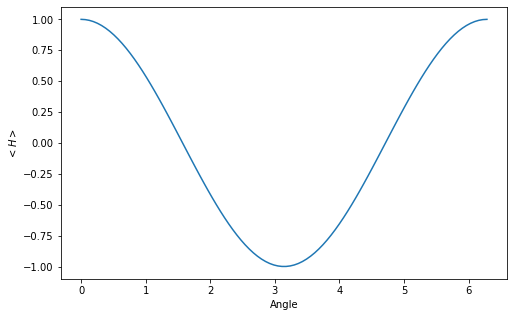

In [13]:
t = np.linspace(0, 2*np.pi, 100)
fig = plt.figure(figsize = (8,5))
plt.plot(t, [expectation_values(tt, H) for tt in t])
plt.xlabel("Angle")
plt.ylabel("$< H >$");

In [14]:
t0 = uniform(0,4*np.pi)
tmin = minimize(expectation_values, t0, args = H)

The minimum eigenvalue is found to be -1:

In [15]:
expectation_values(tmin.x[0], H)

-0.9999999999999996

And the corresponding eigenvector is, up to global phases: 

$$ \vert 01 \rangle + \vert 01 \rangle$$

In [16]:
circuit_init(tmin.x[0])

array([5.92847053e-09+0.j        , 0.00000000e+00+0.70710678j,
       0.00000000e+00+0.70710678j, 5.92847053e-09+0.j        ])

### 3.2. Do it by measuring

In [17]:
def circuit_measure(state, basis):
    nqubits = int(np.log2(len(state)))
    
    change_basis = []
    for b in basis: 
        if b == 1: 
            change_basis.append(Hadamard)
        elif b == 2: 
            change_basis.append(Uzy)
        elif b == 3: 
            change_basis.append(identity)

    U = kron_(change_basis)
    s = U@state
    prob = np.abs(s)**2
    
    outputs = list(itertools.product(*(range(2) for i in range(nqubits))))
    result = np.random.choice(2**nqubits, p = prob)
    result = list(bin(result)[2:].zfill(nqubits))
    return result

def get_parity(result):

    """ Return parity of `result`. """

    parity = +1
    for s in range(len(result)):
        parity *= ((-2)*np.int(result[s]) + 1)
    return parity

In [18]:
def expectation_values_measurements(Nmeasurements, theta, H):
    N = int(np.log2(np.shape(H)[0]))
    coeff = get_coefficients(H)
    basis = list(coeff.keys())
    
    state = circuit_init(theta)
    
    expectation = {}
    for base in basis:
        if base != N*(0,):
            exp = 0
            for i in range(Nmeasurements): 
                output = circuit_measure(state, base)
                #print(output)
                exp += get_parity(output)

            exp /= Nmeasurements
            expectation[base] = exp

    expectation[N*(0,)] = 1

    exp = 0
    for c in coeff.keys(): 
        exp += coeff[c]*expectation[c]

    return exp

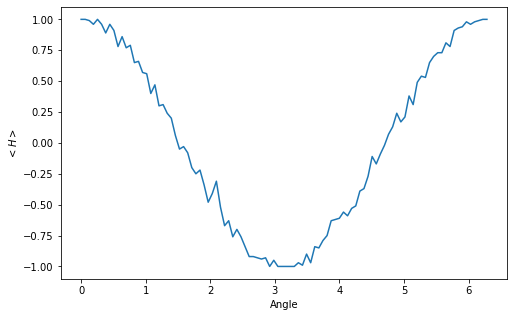

In [19]:
# Set up a number of measurements
Nmeasurements = 100
basis = [(1,1), (2,2), (3,3)]
t = np.linspace(0, 2*np.pi, 100)
fig = plt.figure(figsize = (8,5))

plt.plot(t, [expectation_values_measurements(Nmeasurements, theta, H) for theta in t])
plt.xlabel("Angle")
plt.ylabel("$< H >$");

Naturally, the output is much more noisy than the previous method, but we see that the expectation value of $H$ as the same form as before with respect to the angle $\theta$, reaching its minimum for:

$$\langle H \rangle (\theta = \pi) = -1$$